In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime
from itertools import product

import random
import numpy as np
import scipy as sc
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
sys.path.append('../training/')
from utils import settings

In [2]:
#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
#$ Get configurations passed by batch script
MEAN_CONFIGS = settings.configs['mean']
RESIDUAL_CONFIGS = settings.configs['residual']

In [4]:
def get_errors(tau, conf_threshold=0.2):
    prediction_path = os.path.join(PATHS['full_globe'], 'predictions', f'tau_{tau}')

    target_darray = xr.open_dataarray(os.path.join(prediction_path, 'target.nc'))
    pred_mean_darray = xr.open_dataarray(os.path.join(prediction_path, 'pred_mean.nc'))
    pred_logvar_darray = xr.open_dataarray(os.path.join(prediction_path, 'pred_logvar.nc'))
    linear_darray = xr.open_dataarray(os.path.join(prediction_path, 'dp_pred.nc'))

    mae_ann = np.abs(pred_mean_darray - target_darray).mean(dim='time')
    mae_linear = np.abs(linear_darray - target_darray).mean(dim='time')
    mae_clim = np.abs(target_darray).mean(dim='time')

    # Most confident predictions
    quantile = pred_logvar_darray.quantile(conf_threshold, dim='time')
    conf_preds = pred_mean_darray.where(pred_logvar_darray < quantile, drop=True)
    mae_conf = np.abs(conf_preds - target_darray).mean(dim='time')

    return mae_clim, mae_linear, mae_ann, mae_conf

In [5]:
%%time
mae_clim, mae_linear_10, mae_ann_10, mae_conf_10 = get_errors(tau=10, conf_threshold=0.2)
mae_clim, mae_linear_20, mae_ann_20, mae_conf_20 = get_errors(tau=20, conf_threshold=0.2)
mae_clim, mae_linear_60, mae_ann_60, mae_conf_60 = get_errors(tau=60, conf_threshold=0.2)
mae_clim, mae_linear_120, mae_ann_120, mae_conf_120 = get_errors(tau=120, conf_threshold=0.2)

CPU times: user 44.8 s, sys: 30.8 s, total: 1min 15s
Wall time: 1min 53s


# Publication plots

In [6]:
cmap_magma = plt.get_cmap('magma_r')
cmap_magma.name

'magma_r'

In [7]:
cmap_magma = plt.get_cmap('magma_r')
cmap_magma = mpl.colors.LinearSegmentedColormap.from_list(
    cmap_magma.name,
    cmap_magma(np.linspace(0, 0.8, 256))
)
cmap_magma = cmap_magma.resampled(20)

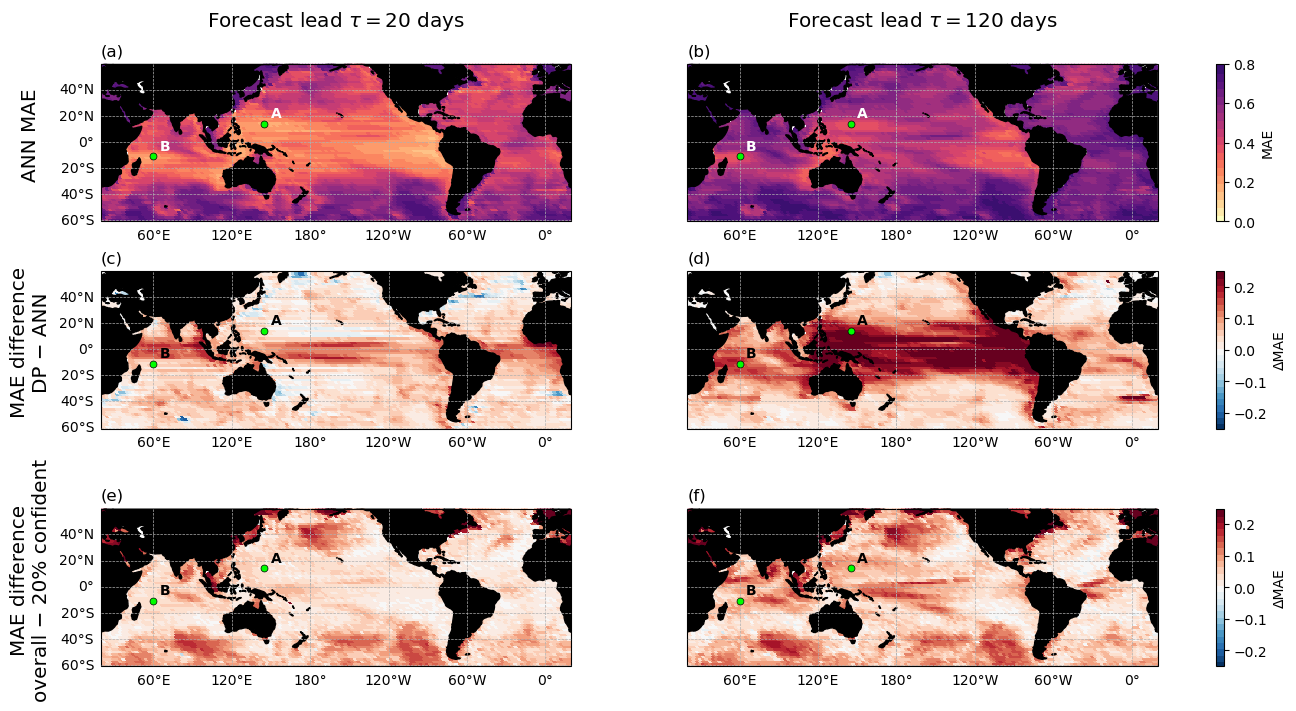

In [8]:
icoords = [4710, 3282]

fig, axes = plt.subplot_mosaic(
    [['a', 'b'], ['c', 'd'], ['e', 'f']],
    figsize=(13, 7), 
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    layout='constrained'
)

# Plots
cax_0 = mae_ann_20.plot(
    ax=axes['a'], transform=ccrs.PlateCarree(), cmap=cmap_magma,
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=0.8, zorder=0
)
cax_0 = mae_ann_120.plot(
    ax=axes['b'], transform=ccrs.PlateCarree(), cmap=cmap_magma,
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=0.8, zorder=0
)

cax_1 = (mae_linear_20 - mae_ann_20).plot(
    ax=axes['c'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r', 25),
    edgecolor='face', 
    add_colorbar=False, vmin=-0.25, vmax=0.25, zorder=0
)
cax_1 = (mae_linear_120 - mae_ann_120).plot(
    ax=axes['d'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r', 25),
    edgecolor='face', 
    add_colorbar=False, vmin=-0.25, vmax=0.25, zorder=0
)

cax_2 = (mae_ann_20 - mae_conf_20).plot(
    ax=axes['e'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r', 25),
    edgecolor='face',
    add_colorbar=False, vmin=-0.25, vmax=0.25, zorder=0
)
cax_2 = (mae_ann_120 - mae_conf_120).plot(
    ax=axes['f'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r', 25),
    edgecolor='face',
    add_colorbar=False, vmin=-0.25, vmax=0.25, zorder=0
)

# Scatter plot
pointlabels = ['A', 'B']
for i, icoord in enumerate(icoords):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    lat = np.round(lat)
    lon = np.round(lon)
    for label, ax in axes.items():
        labelcolor = 'w' if label in ['a', 'b'] else 'k'
        ax.plot(
            [lon], [lat], ls='', marker='.', mfc='lime', ms=10, mec='k',
            mew=0.5, transform=ccrs.PlateCarree(), zorder=4
        )
        ax.text(
            lon+5, lat+5, pointlabels[i], c=labelcolor, fontweight='bold', 
            transform=ccrs.PlateCarree(), zorder=4
        )

# Colorbars
cb = plt.colorbar(
    cax_0, ax=[axes['a'], axes['b']], label='MAE', # shrink=0.8, 
    location='right', orientation='vertical')
cb.solids.set_edgecolor('face')

cb = plt.colorbar(
    cax_1, ax=[axes['c'], axes['d']], label='\u0394MAE', # shrink=0.8, 
    location='right', orientation='vertical')
cb.solids.set_edgecolor('face')

cb = plt.colorbar(
    cax_2, ax=[axes['e'], axes['f']], label='\u0394MAE', # shrink=0.8, 
    location='right', orientation='vertical')
cb.solids.set_edgecolor('face')

for label, ax in axes.items():
    ax.set(title=None)
    ax.add_feature(cartopy.feature.LAND, color='k', zorder=2)
    gl = ax.gridlines(ls='--', lw=0.5, zorder=3)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True # if label in ['e', 'f'] else False
    gl.left_labels = True if label in ['a', 'c', 'e'] else False
    ax.set_title(f'({label})', loc='left')

# Labels
for label, tau in zip(['a', 'b'], [20, 120]):
    axes[label].text(
        0.5, 1.2, r'Forecast lead $\tau = {{{}}}$ days'.format(tau),
        va='bottom', ha='center', transform=axes[label].transAxes,
        fontsize='x-large'
    )
axes['a'].text(
    -0.15, 0.55, 'ANN MAE', fontsize='x-large', rotation='vertical',
    va='center', ha='center', transform=axes['a'].transAxes,
)
axes['c'].text(
    -0.15, 0.55, 'MAE difference\nDP \u2212 ANN', fontsize='x-large', rotation='vertical',
    va='center', ha='center', transform=axes['c'].transAxes,
)
axes['e'].text(
    -0.15, 0.55, 'MAE difference\noverall \u2212 20% confident', fontsize='x-large', rotation='vertical',
    va='center', ha='center', transform=axes['e'].transAxes,
)
plt.savefig('error_maps.pdf', dpi=300, bbox_inches='tight')

In [11]:
diff_dp_ann_20 = (mae_linear_20 - mae_ann_20)
diff_dp_ann_120 = (mae_linear_120 - mae_ann_120)

# Number of networks where ANN has lower MAE than DP
outperformers_20 = (diff_dp_ann_20 >= 0).sum().item()
outperformers_120 = (diff_dp_ann_120 >= 0).sum().item()

print("Networks with lower MAE than DP (tau=20): ", outperformers_20)
print("Networks with lower MAE than DP (tau=120):", outperformers_20)

Networks with lower MAE than DP (tau=20):  6043
Networks with lower MAE than DP (tau=120): 6043
6590


In [15]:
print("Total number of networks:", (~np.isnan(diff_dp_ann_20)).sum().item())
print("Percentage of networks outperforming DP, (tau=20):", outperformers_20/6590)
print("Percentage of networks outperforming DP, (tau=120):", outperformers_120/6590)

Total number of networks: 6590
Percentage of networks outperforming DP, (tau=20): 0.9169954476479515
Percentage of networks outperforming DP, (tau=120): 0.9837632776934749


In [16]:
diff_ann_conf_20 = (mae_ann_20 - mae_conf_20)
diff_ann_conf_120 = (mae_ann_120 - mae_conf_120)

num_useful_conf_20 = (diff_ann_conf_20 >= 0).sum().item()
num_useful_conf_120 = (diff_ann_conf_120 >= 0).sum().item()

print("Percentage of networks outperforming DP, (tau=20):", num_useful_conf_20/6590)
print("Percentage of networks outperforming DP, (tau=120):", num_useful_conf_120/6590)

Percentage of networks outperforming DP, (tau=20): 0.9943854324734446
Percentage of networks outperforming DP, (tau=120): 0.982701062215478


---
# All time lags

In [8]:
mae_linears = [mae_linear_10, mae_linear_20, mae_linear_60, mae_linear_120]
mae_anns = [mae_ann_10, mae_ann_20, mae_ann_60, mae_ann_120]
mae_confs = [mae_conf_10, mae_conf_20, mae_conf_60, mae_conf_120]

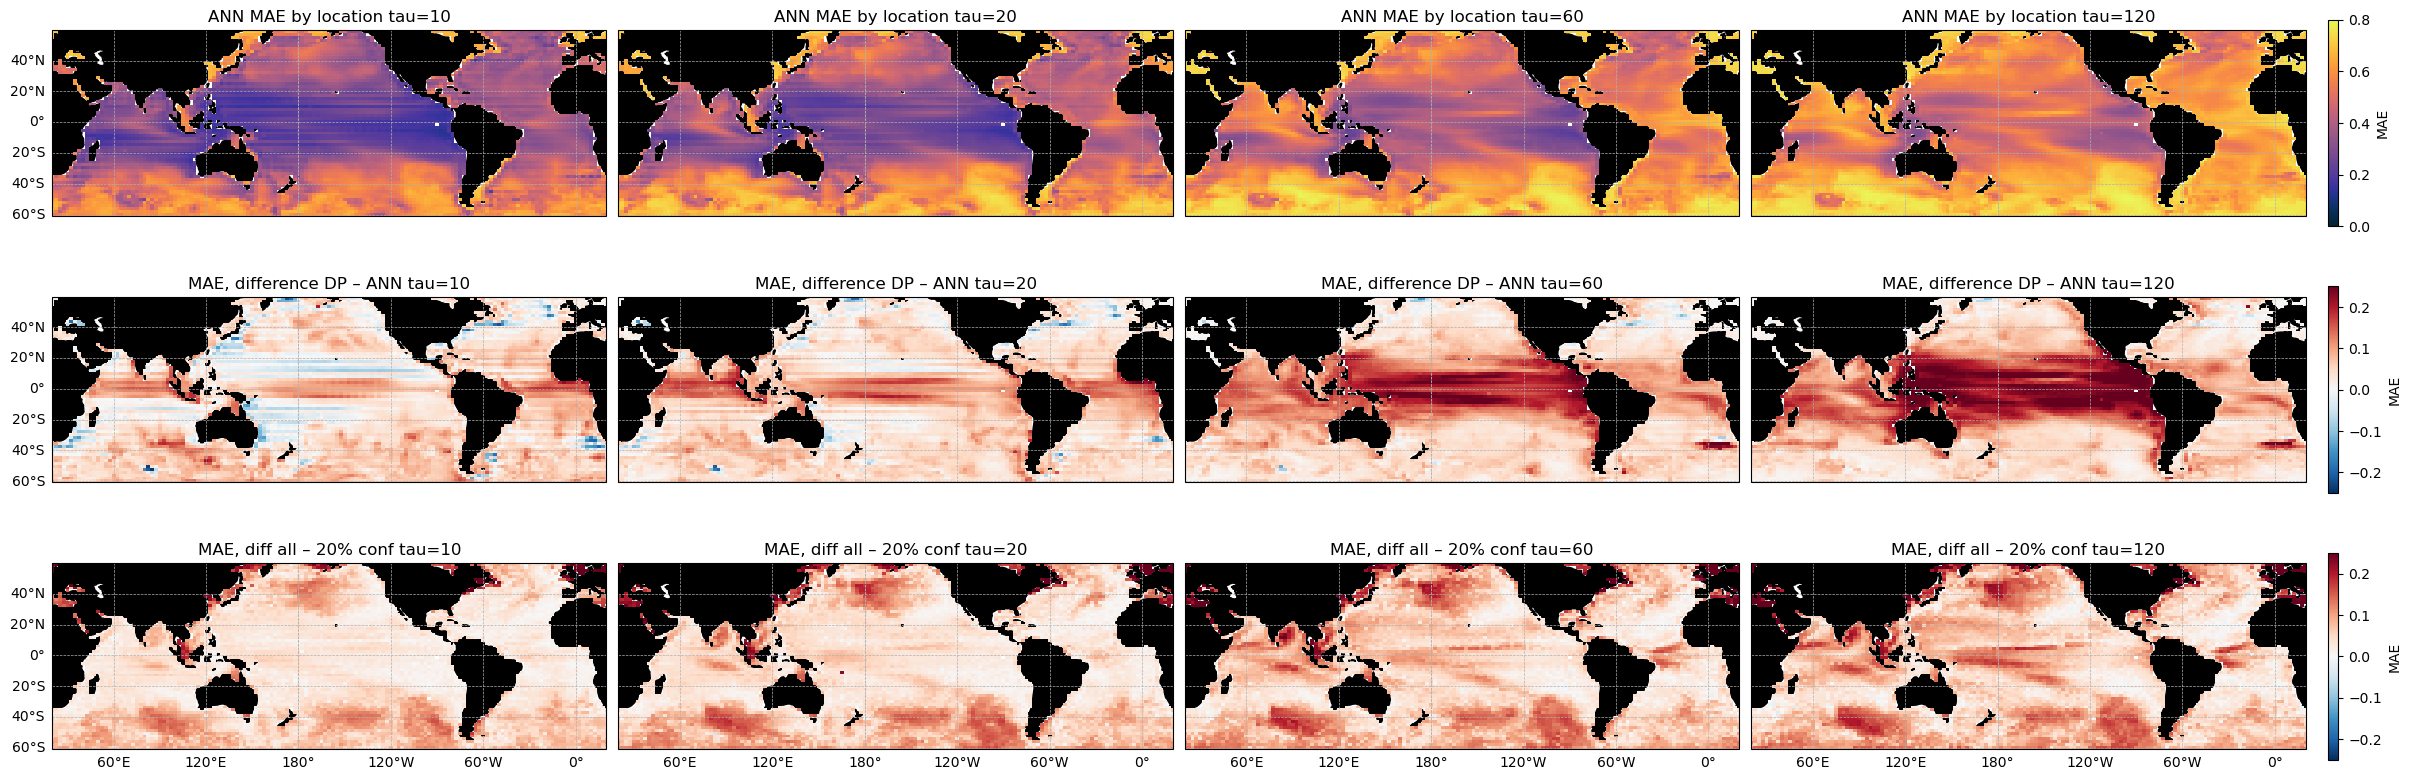

In [27]:
fig, axes = plt.subplots(
    ncols=4, nrows=3, figsize=(24,8), 
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    layout='constrained'
)

taus = [10, 20, 60, 120]
for j, tau in enumerate(taus):
    mae_linear = mae_linears[j]
    mae_ann = mae_anns[j]
    mae_conf = mae_confs[j]

    cax_0 = mae_ann.plot(
        ax=axes[0, j], transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal,
        add_colorbar=False, vmin=0, vmax=0.8
    )
    axes[0, j].set(title=f'ANN MAE by location tau={tau}')

    cax_1 = (mae_linear - mae_ann).plot(
        ax=axes[1, j], transform=ccrs.PlateCarree(), cmap='RdBu_r',
        add_colorbar=False, vmin=-0.25, vmax=0.25
    )
    axes[1, j].set(title=f'MAE, difference DP \u2013 ANN tau={tau}')

    cax_2 = (mae_ann - mae_conf).plot(
        ax=axes[2, j], transform=ccrs.PlateCarree(), cmap='RdBu_r',
        add_colorbar=False, vmin=-0.25, vmax=0.25
    )
    axes[2, j].set(title=f'MAE, diff all \u2013 20% conf tau={tau}')

cb = plt.colorbar(
    cax_0, ax=[axes[0, j] for j in range(4)], label='MAE', shrink=0.8, pad=0.01,
    location='right', orientation='vertical')
cb = plt.colorbar(
    cax_1, ax=[axes[1, j] for j in range(4)], label='MAE', shrink=0.8, pad=0.01,
    location='right', orientation='vertical')
cb = plt.colorbar(
    cax_2, ax=[axes[2, j] for j in range(4)], label='MAE', shrink=0.8, pad=0.01,
    location='right', orientation='vertical')

for (i,j) in product(np.arange(3), np.arange(4)):
    axes[i,j].add_feature(cartopy.feature.LAND, color='k')
    gl = axes[i,j].gridlines(ls='--', lw=0.5)
    gl.top_labels = False
    gl.bottom_labels = True if i==2 else False
    gl.left_labels = True if j==0 else False
    gl.right_labels = False

# fig.tight_layout()
# fig.savefig('error_all_tau.pdf', dpi=300)